# Dinamic Light Scattering
D. Pomogaev and E. Imaykina

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # I use seborn because I love seaborn
from scipy.optimize import curve_fit

In [25]:
# Adding gold data
data = pd.DataFrame([
    {'theta':  20, 'I, cps': 805e3, 'dI, cps': 2e4, 'tc, ms': 3.570, 'dtc, s': 1.118},
    {'theta':  30, 'I, cps': 585e3, 'dI, cps': 2e4, 'tc, ms': 2.056, 'dtc, s': 0.572},
    {'theta':  40, 'I, cps': 478e3, 'dI, cps': 5e3, 'tc, ms': 1.189, 'dtc, s': 0.805},
    {'theta':  50, 'I, cps': 410e3, 'dI, cps': 6e3, 'tc, ms': 0.619, 'dtc, s': 0.158},
    {'theta':  60, 'I, cps': 342e3, 'dI, cps': 6e3, 'tc, ms': 0.483, 'dtc, s': 0.132},
    {'theta':  70, 'I, cps': 345e3, 'dI, cps': 6e3, 'tc, ms': 0.356, 'dtc, s': 0.109},
    {'theta':  80, 'I, cps': 333e3, 'dI, cps': 4e3, 'tc, ms': 0.288, 'dtc, s': 0.160},
    {'theta':  90, 'I, cps': 323e3, 'dI, cps': 9e3, 'tc, ms': 0.228, 'dtc, s': 0.063},
    {'theta': 100, 'I, cps': 323e3, 'dI, cps': 9e3, 'tc, ms': 0.205, 'dtc, s': 0.070},
    {'theta': 120, 'I, cps': 368e3, 'dI, cps': 3e3, 'tc, ms': 0.167, 'dtc, s': 0.069},
    {'theta': 130, 'I, cps': 387e3, 'dI, cps': 5e3, 'tc, ms': 0.143, 'dtc, s': 0.075},
    {'theta': 140, 'I, cps': 462e3, 'dI, cps': 1e4, 'tc, ms': 0.121, 'dtc, s': 0.048},
])
data['sample'] = 'gold'

# Adding sulfur data
data2 = pd.DataFrame([
    [ 20, 2.8e6, 150e3, 21.52, 4.951],
    [ 30, 2.3e6, 100e3, 9.215, 2.626],
    [ 40, 205e4, 100e3, 5.027, 1.664],
    [ 50, 172e4, 3.0e4, 3.997, 0.574],
    [ 60, 1.5e6, 3.0e4, 2.998, 1.026],
    [ 70, 127e4, 2.0e4, 2.190, 0.478],
    [ 80, 113e4, 2.0e4, 1.698, 0.358],
    [ 90, 105e4, 1.5e4, 1.348, 0.269],
    [100, 940e3, 1.0e4, 1.003, 0.299],
    [110, 940e3, 2.0e4, 0.991, 0.236],
    [120, 880e3, 1.0e4, 0.780, 0.067],
    [130, 935e3, 1.5e4, 0.652, 0.069],
    [140, 103e4, 1.5e4, 0.554, 0.047]
], columns = ('theta', 'I, cps', 'dI, cps', 'tc, ms', 'dtc, s'))
data2['sample'] = 'sulfur'

# Merge data from two df's into one
data = pd.concat((data, data2))
del data2
with open('dls/tex_table3.txt', 'w') as file:
    data.to_latex(file, index=False, float_format='%.2f')

data.head()

,theta,"I, cps","dI, cps","tc, ms","dtc, s",sample
0,20,805000.0,20000.0,3.570,1.118,gold
1,30,585000.0,20000.0,2.056,0.572,gold
2,40,478000.0,5000.0,1.189,0.805,gold
3,50,410000.0,6000.0,0.619,0.158,gold
4,60,342000.0,6000.0,0.483,0.132,gold


In [33]:
# Add normilized Intensity with error
b = pd.DataFrame()
for mat in ('gold', 'sulfur'):
    a = data[data['sample'] == mat]
    a['I_norm'] = a['I, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]
    a['dI_norm'] = a['dI, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]
    b = pd.concat((b, a), axis=0)
data_new = pd.merge(data, b, 'inner', ('sample', 'theta', 'I, cps', 'dI, cps', 'tc, ms', 'dtc, s'))
data_new

<ipython-input-33-f2713ce6b5f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['I_norm'] = a['I, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]
<ipython-input-33-f2713ce6b5f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['dI_norm'] = a['dI, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]
<ipython-input-33-f2713ce6b5f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,theta,"I, cps","dI, cps","tc, ms","dtc, s",sample,I_norm,dI_norm
0,20,805000.0,20000.0,3.570,1.118,gold,2.492260,0.061920
1,30,585000.0,20000.0,2.056,0.572,gold,1.811146,0.061920
2,40,478000.0,5000.0,1.189,0.805,gold,1.479876,0.015480
3,50,410000.0,6000.0,0.619,0.158,gold,1.269350,0.018576
4,60,342000.0,6000.0,0.483,0.132,gold,1.058824,0.018576
5,70,345000.0,6000.0,0.356,0.109,gold,1.068111,0.018576
6,80,333000.0,4000.0,0.288,0.160,gold,1.030960,0.012384
7,90,323000.0,9000.0,0.228,0.063,gold,1.000000,0.027864
8,100,323000.0,9000.0,0.205,0.070,gold,1.000000,0.027864
9,120,368000.0,3000.0,0.167,0.069,gold,1.139319,0.009288


<Figure size 576x576 with 0 Axes>

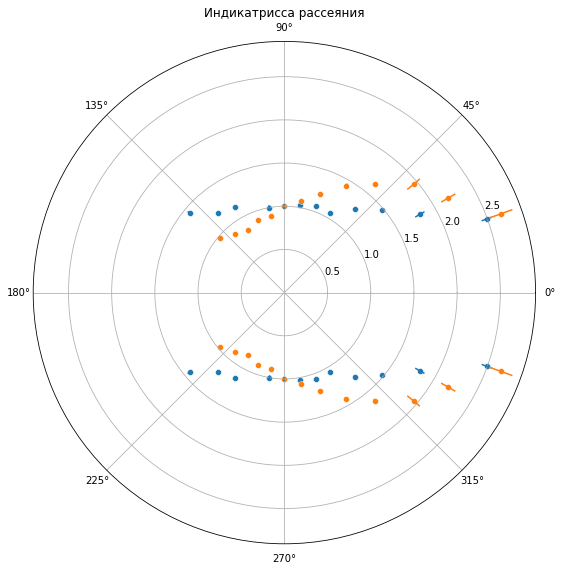

<Figure size 576x576 with 0 Axes>

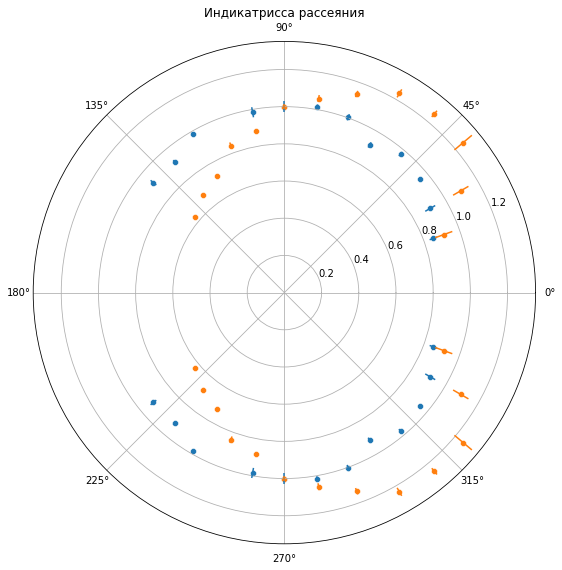

In [34]:
# Build indicatrice of refraction in polar coordinates
data_new['theta, rad'] = data_new['theta']/180 * np.pi
data_new['sin theta'] = np.sin(data_new['theta, rad'])
data_new['theta, rad -1'] = data_new['theta, rad'] * -1
data_new['I_norm_sined'] = data_new['I_norm'] * data_new['sin theta']
data_new['dI_norm_sined'] = data_new['dI_norm'] * data_new['sin theta']

data_new_modified = data_new[data_new['sample'] == 'gold']
def polar_builder(y_str, dy_str, filename):
    plt.figure(figsize=(8, 8))
    '''Build an indicatrice in polar coordinates using spiecified column names and filename'''
    g = sns.FacetGrid(data_new, hue="sample",
                    subplot_kws=dict(projection='polar'), height=8,
                    sharex=False, sharey=False, despine=False)

    g.map(sns.scatterplot, 'theta, rad', y_str)
    g.map(sns.scatterplot, 'theta, rad -1', y_str, label=None)
    g.map(plt.errorbar, 'theta, rad', y_str, dy_str, linestyle='', label=None)
    g.map(plt.errorbar, 'theta, rad -1', y_str, dy_str, linestyle='', label=None)

    plt.title('Индикатрисса рассеяния')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.savefig(filename)

polar_builder('I_norm', 'dI_norm', 'dls/indicatrice1.jpg') # just intensity
polar_builder('I_norm_sined', 'dI_norm_sined', 'dls/indicatrice2.jpg') # sined intensity

data_new['I, Mcps'] = data_new['I, cps']/1e6
data_new['dI, Mcps'] = data_new['dI, cps']/1e6
data_new_export = data_new[['sample', 'theta', 'sin theta','I, Mcps', 'dI, Mcps',  'I_norm', 'I_norm_sined', 'dI_norm_sined']]
with open('dls/tex_table1.txt', 'w') as file:
    data_new_export.to_latex(
        file,
        index=False,
        float_format='%.2f',
        multicolumn=True,
        caption='INSERT TITLE HERE'
    )
data_new.to_csv('dls/raw_data.csv', float_format='%.3f')

1.3025598668549892e-11 2.5995731501521295e-12


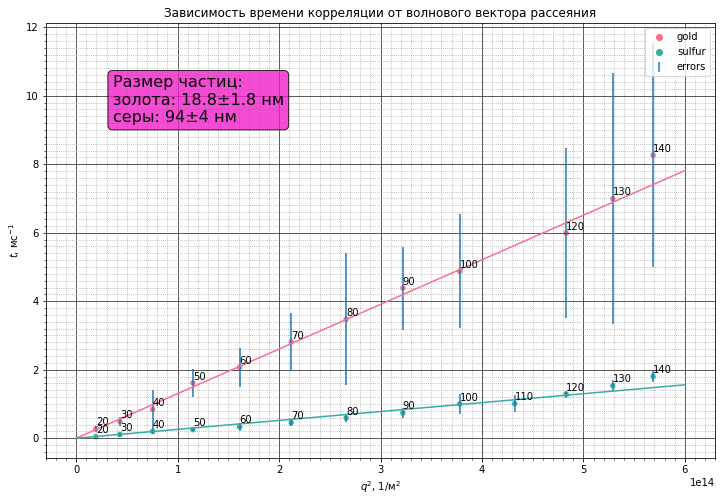

In [17]:
lmb = 658.6e-9 # LASER wavelength
eta = 8.9e-4 # Pa*s - water viscousity

data['tc_inv'] = 1/data['tc, ms']
data['dtc_inv'] = data['dtc, s']/(data['tc, ms'])**2
data['I_square'] = data['I_norm']**2
data['q_sq'] = (4*np.pi*1.33/lmb*np.sin(data['theta, rad']/2))**2

f = lambda x, k: k*x

data_g = data[data['sample'] == 'gold']
data_s = data[data['sample'] == 'sulfur']
popt1, pcov1 = curve_fit(f, data_g['q_sq'], data_g['tc_inv'], sigma=data_g['dtc_inv'], absolute_sigma=True)
popt2, pcov2 = curve_fit(f, data_s['q_sq'], data_s['tc_inv'], sigma=data_s['dtc_inv'], absolute_sigma=True)

xs = np.linspace(0, 6e14)
ys1 = f(xs, *popt1)
ys2 = f(xs, *popt2)

plt.figure(figsize=(12, 8))
ax = plt.axes()
pallete = sns.husl_palette(2)
wuh = iter(pallete)

# Build points with error bars
sns.scatterplot(data = data, x='q_sq', y='tc_inv', hue='sample', palette=pallete)
plt.errorbar(data=data, x = 'q_sq', y='tc_inv', yerr='dtc_inv', linestyle='', label='errors')

# Build fitting line
sns.lineplot(x=xs, y=ys1, label=None, color=next(wuh))
sns.lineplot(x=xs, y=ys2, label=None, color=next(wuh))

# Add angle labels
for i, row in data.iterrows():
    plt.text(x=row['q_sq']+0.02, y=row['tc_inv']+0.1, s=row['theta'])

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(1e13)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(0.2)
ax.yaxis.set_minor_locator(mly)

R = lambda D: 1.38e-23*298/(6*3.1415*eta*D)

R1 = R(popt1[0]*1e3)
dR1 = np.sqrt(pcov1[0][0])/popt1[0]*R1

R2 = R(popt2[0]*1e3)
dR2 = np.sqrt(pcov2[0][0])/popt2[0]*R2

props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.8)
text = 'Размер частиц:\nзолота: {g:.3g}±{dg:.2g} нм\nсеры: {s:.2g}±{ds:.1g} нм'.format(
    g = R1*1e9, dg = dR1*1e9,
    s = R2*1e9, ds = dR2*1e9
)
plt.text(0.10, 0.88, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

plt.title('Зависимость времени корреляции от волнового вектора рассеяния')
plt.xlabel(r'$q^2$, $1/$м$^2$')
plt.ylabel(r'$t$, мс$^{-1}$')
plt.savefig('dls/qt.jpg')

data['q_sq_Terra'] = data['q_sq']/1e12
data_export = data[['sample', 'theta', 'q_sq_Terra', 'tc, ms', 'dtc, s', 'tc_inv', 'dtc_inv']]
with open('dls/tex_table2.txt', 'w') as file:
    data_export.to_latex(
        file,
        index=False,
        float_format='%.3g',
        caption=' '
    )

print(popt1[0]*1e3, popt2[0]*1e3)

In [6]:
curve90 = pd.read_csv('08.04ИмайкинаПомогаев/90 curve.txt', sep='\t\t', header=4,
                      names=['channel', 'value'], comment='***')
exp90 = pd.read_csv('08.04ИмайкинаПомогаев/exp 90 linear sulfur.txt', sep='\t\t', header=4,
                      names=['channel', 'value'], comment='***')
time20 = pd.read_csv('08.04ИмайкинаПомогаев/20 time.txt', sep='\t\t', header=4,
                      names=['time', 'value'], comment='***')
time20.head()

<ipython-input-6-2e0dd45f9120>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  curve90 = pd.read_csv('08.04ИмайкинаПомогаев/90 curve.txt', sep='\t\t', header=4,
<ipython-input-6-2e0dd45f9120>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  exp90 = pd.read_csv('08.04ИмайкинаПомогаев/exp 90 linear sulfur.txt', sep='\t\t', header=4,
<ipython-input-6-2e0dd45f9120>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  t

,time,value
0,0.000002,0.0
1,0.000002,0.0
2,0.000003,0.0
3,0.000003,0.0
4,0.000004,0.0


0.0014722724122973733


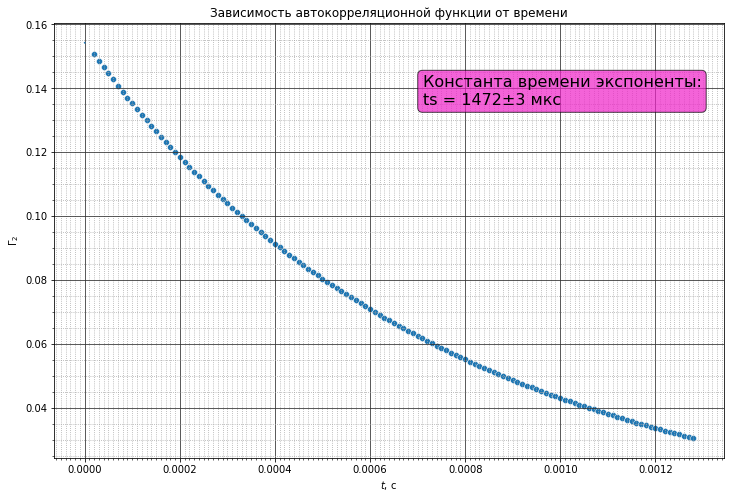

In [15]:
f2 = lambda x, tc, A, B: A*np.exp(-2*x/tc) + B

exp90['t'] = 10e-6*exp90['channel']

popt3, pcov3 = curve_fit(f2, exp90['t'], exp90['value'], p0=(1e-4, 0.1, 0))
xs = np.linspace(0, 2e-9*140)
ys = f2(xs, *popt3)

plt.figure(figsize=(12, 8))
ax = plt.axes()
sns.scatterplot(data=exp90, x='t', y='value')
sns.lineplot(x=xs, y=ys)
print(popt3[0])

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(1e-5)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(0.005)
ax.yaxis.set_minor_locator(mly)

props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.7)
text = 'Константа времени экспоненты:\nts = {s:.4g}±{ds:.1g} мкс'.format(
    s = popt3[0]*1e6, ds = np.sqrt(pcov3[0][0])*1e6
)
plt.text(0.55, 0.88, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

plt.title('Зависимость автокорреляционной функции от времени')
plt.xlabel(r'$t$, с')
plt.ylabel(r'$\Gamma_2$')
plt.savefig('dls/exponence.jpg')

<Axes: xlabel='channel', ylabel='value'>

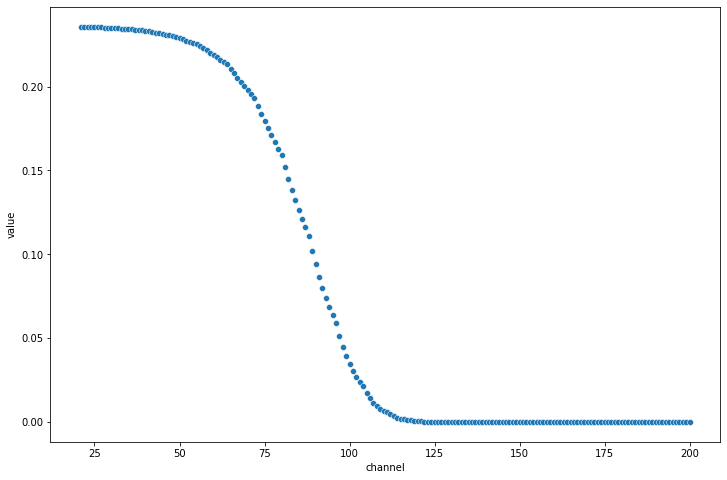

In [8]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=curve90, x='channel', y='value')

статического и динамического рассеяния света для исследования наночастиц и макромолекул в растворах